In [1]:
%reset -f
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib
import vep_prob_models
import lib.plots.stan
import dyn_model

/home/anirudh/anaconda3/envs/python3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_dir = 'datasets/id002_cj'
results_dir = 'results/exp10/exp10.66'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

consts = dict()
obs = dict()
network = np.load(f'{data_dir}/CJ_network.npz')
consts['SC'] = network['SC']
consts['SC'] = consts['SC'] / consts['SC'].max()
consts['SC'][np.diag_indices(consts['SC'].shape[0])] = 0
consts['gain'] = network['gain_mat']

slp = np.load(f'{data_dir}/CJ_fit_trgt.npz')['fit_trgt']
obs['slp'] = slp[0:-1:5,:][40:220]
slp_sqrd = obs['slp']**2
consts['nt'], consts['ns'] = obs['slp'].shape
# consts['wnd_len'] = 50
# consts['n_wndws'] = int(consts['nt'] / consts['wnd_len'])
# obs['snsr_pwr'] = np.zeros((consts['n_wndws'], consts['ns']))
# for i in range(consts['n_wndws']):
#     obs['snsr_pwr'][i] = np.sum(slp_sqrd[i*consts['wnd_len']:(i+1)*consts['wnd_len']], axis=0)
obs['snsr_pwr'] = slp_sqrd.sum(axis=0)
obs['snsr_pwr'] = obs['snsr_pwr'] / obs['snsr_pwr'].max()

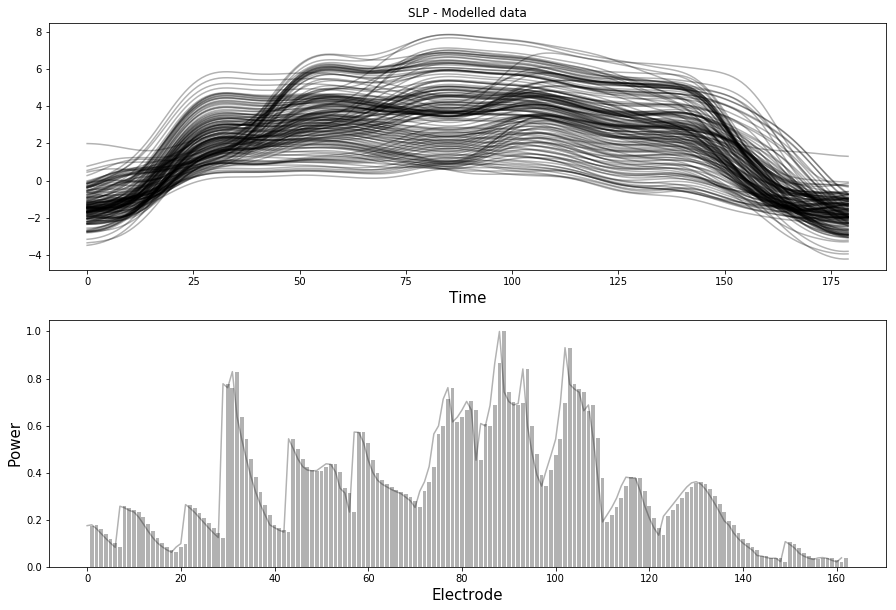

In [3]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(obs['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.title('SLP - Modelled data')
plt.subplot(212)
plt.bar(np.arange(1,consts['gain'].shape[0]+1), obs['snsr_pwr'], color='black', alpha=0.3)
plt.plot(obs['snsr_pwr'].T, color='black', alpha=0.3)
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/fitting_data.png')

In [4]:
# importlib.reload(vep_prob_models)

consts['nn'] = consts['SC'].shape[0]
# consts['ns'] = consts['gain'].shape[0]
consts['I1'] = 3.1
consts['time_step'] = 0.1
consts['x_init'] = -2.0*np.ones(consts['nn'])
consts['z_init'] = 3.5*np.ones(consts['nn'])
consts['epsilon_slp'] = 0.001
consts['epsilon_snsr_pwr'] = 0.1
consts['alpha'] = 1.0

params_init = dict()
params_init['x0_star'] = np.zeros(consts['nn'])
params_init['amplitude_star'] = 0.0
params_init['offset_star'] = 0.0
params_init['K_star'] = 0.0
params_init['tau0_star'] = 0.0
# params_init['eps_slp_star'] = 0.0
# params_init['eps_snsr_pwr_star'] = 0.0
# params_init['x0'] = -2.5*np.ones(consts['nn'])
# params_init['amplitude'] = 1.0
# params_init['offset'] = 0.0
# params_init['K'] = 0.0
# params_init['tau0'] = 30

# max_depth = 15
# delta = 0.95
# fname_suffix = f'hyper_fixed_md{max_depth}_delta{delta}'

In [5]:
vep_mdl = vep_prob_models.vep_ode(consts=consts, obs=obs)

In [6]:
niters = 10000
optmzr = pm.SVGD(n_particles=4, jitter=0.1, temperature=1, model=vep_mdl.model, start=params_init)
post_approx = optmzr.fit(niters)
# for i in range(10):
#     optmzr.refine(1000)


100%|██████████| 10000/10000 [13:48<00:00, 12.06it/s]


In [ ]:
try:
    i = 0
    while(True):
        print(f'Iterations {niters+i*100} - {niters+(i+1)*100}')
        optmzr.refine(100, progressbar=False)
        trace1 = optmzr.approx.sample(1000)
        i += 1
except FloatingPointError as err:
    pass

### Save the trace

In [13]:
save_dir_name = 'samples_4particles_jitter0.1_temp1'
os.makedirs(f'{results_dir}/{save_dir_name}')
pm.backends.save_trace(trace,f'{results_dir}/{save_dir_name}', overwrite=True)

'results/exp10/exp10.66/samples_4particles_jitter0.1_temp1'

In [ ]:
# trace = pm.backends.load_trace(f'{results_dir}', model=vep_mdl.model)
trace = np.load(f'{results_dir}/0/samples.npz')

In [7]:
with vep_mdl.model:
    trace = post_approx.sample(1000)

In [ ]:
with vep_mdl.model:
    trace = pm.backends.text.load(results_dir)

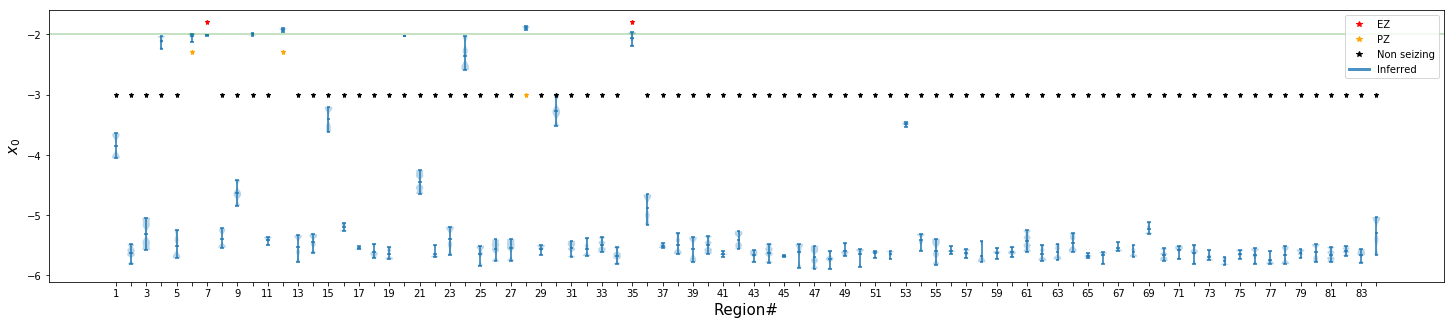

In [8]:
syn_data = np.load('datasets/id002_cj/CJ_syn_tvb_ez=6-34_pz=27-5-11.npz')
x0_true = syn_data['x0']
ez = syn_data['ez']
pz= np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))
lib.plots.stan.x0_violin_syn(trace['x0'], x0_true, ez, pz, figsize=(25,5))

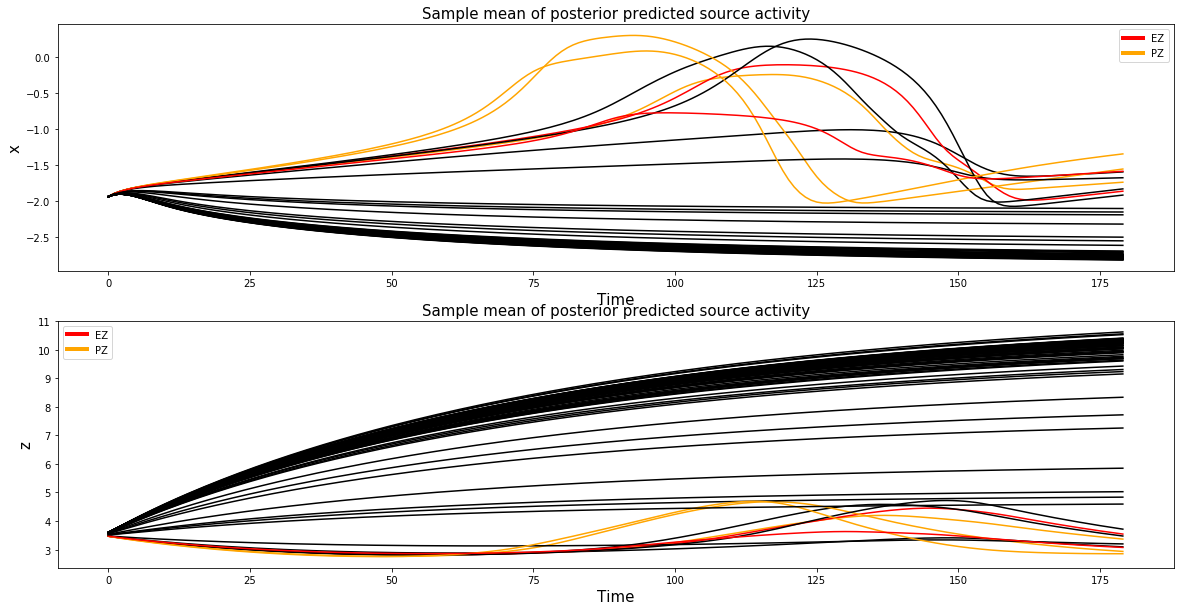

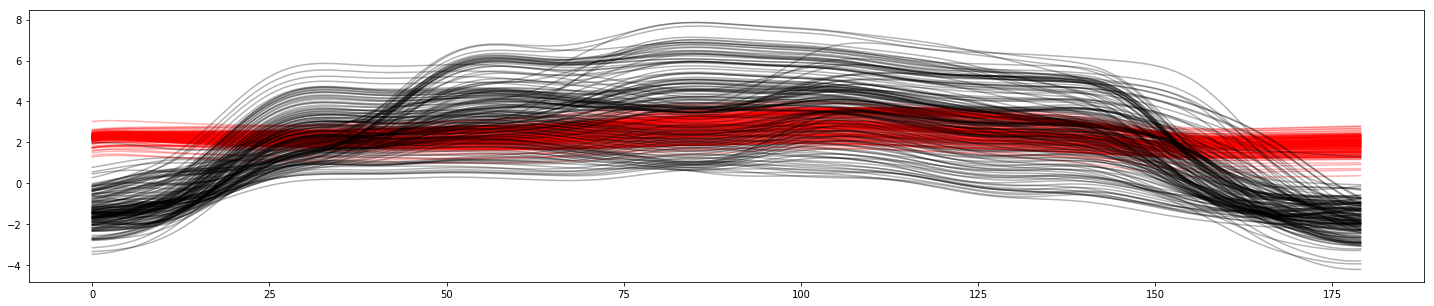

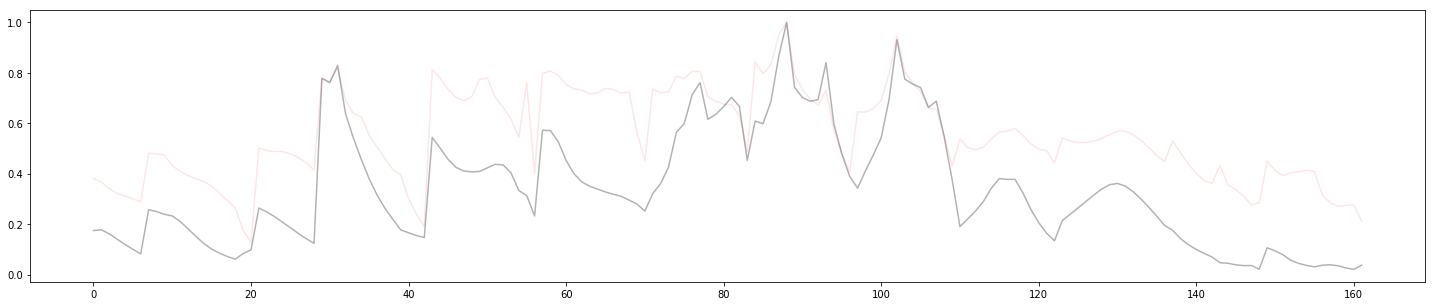

In [9]:
lib.plots.stan.plot_source(trace['x'].mean(axis=0), trace['z'].mean(axis=0), ez, pz)
plt.figure(figsize=(25,5))
plt.plot(trace['mu_slp'].mean(axis=0), 'r', alpha=0.3);
plt.plot(obs['slp'], 'k', alpha=0.3);
plt.figure(figsize=(25,5))
plt.plot(trace['mu_snsr_pwr'].mean(axis=0).T, 'r', alpha=0.1)
plt.plot(obs['snsr_pwr'].T, 'k', alpha=0.3)


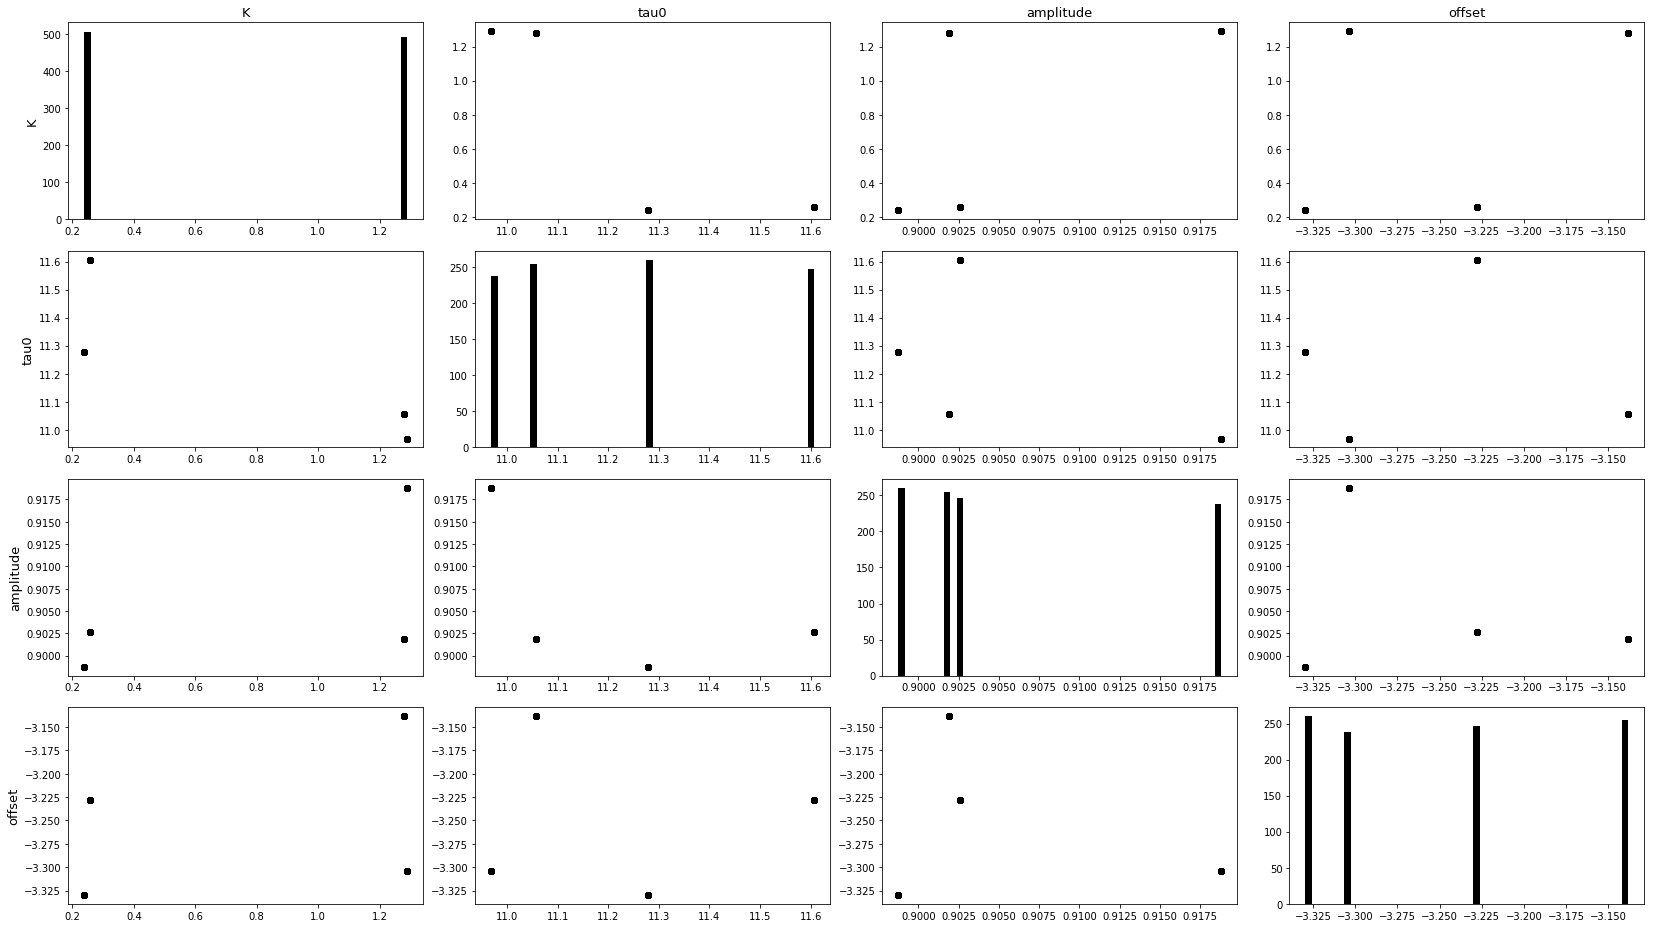

In [10]:
lib.plots.stan.pair_plots(trace, ['K', 'tau0', 'amplitude', 'offset'])

In [ ]:
post_pred = pm.sample_posterior_predictive(trace1, model=vep_mdl.model)

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(post_pred['slp'][20], 'r', alpha=0.3);
plt.plot(obs['slp'], 'k', alpha=0.3);
plt.figure(figsize=(25,5))
plt.bar(np.r_[0:consts['ns']], obs['snsr_pwr'], color='black', alpha=0.3)
plt.bar(np.r_[0:consts['ns']], trace1['mu_snsr_pwr'].mean(axis=0), color='red', alpha=0.5)

In [11]:
ep = dyn_model.Epileptor_2D()
params = dict()
params['nn'] = consts['nn']
params['nt'] = consts['nt']
params['x_init'] = consts['x_init']
params['z_init'] = consts['z_init']
params['time_step'] = consts['time_step']
params['I1'] = consts['I1']
params['SC'] = consts['SC']
x = np.zeros((trace['x0'].shape[0], consts['nt'], consts['nn']))
z = np.zeros((trace['x0'].shape[0], consts['nt'], consts['nn']))
slp = np.zeros((trace['x0'].shape[0], consts['nt'], consts['ns']))
for i in range(trace['x0'].shape[0]):
    params['tau0'] = trace['tau0'][i]
    params['K'] = trace['K'][i]
    params['x0'] = trace['x0'][i]
    sim_out = ep.sim(params)
    x[i] = sim_out['x']
    z[i] = sim_out['z']
    slp[i] = trace['amplitude'][i]*(np.log(consts['gain']@np.exp(x[i].T)) + trace['offset'][i]).T

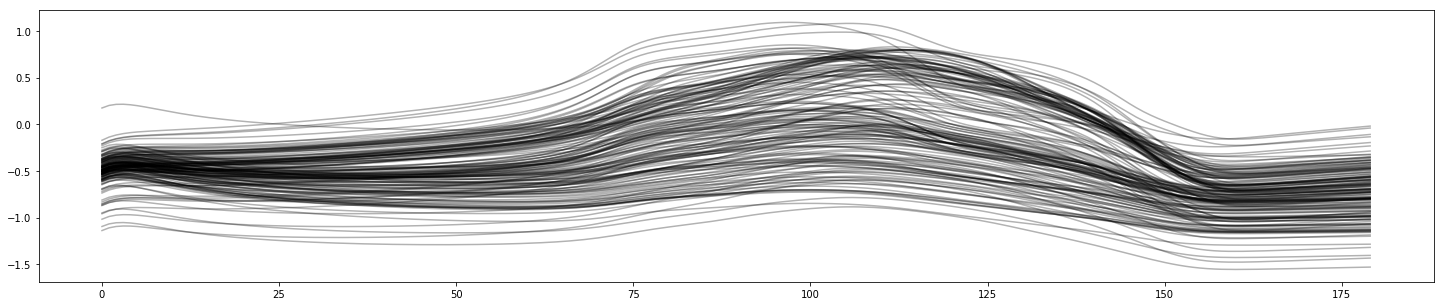

In [12]:
plt.figure(figsize=(25,5))
plt.plot(slp.mean(axis=0), 'k', alpha=0.3);